# The time to mutational meltdown

The purpose of this notebook is to guide through the analysis of our derived analytical expression for the mean extinction time and the comparison with results from our stochastic simulations.

The script `analytical_results.jl` contains all derived equations and the script `simulate_mutational_meltdown.jl` the code of our simulations.

In [1]:
using Plots, Distributions, DataFrames, CSV, Plots.PlotMeasures, Roots, SpecialFunctions, Optim
include("simulate_mutational_meltdown.jl")
include("analytical_results.jl")

maximal_s (generic function with 1 method)

## Distribution of number of mutations

The function `extinction_time_dist_mutations()` simulates the population dynamics for a set of global parameters (founder population size, carrying capacity, maximal number of generations until simulation is aborted, wild-type reproduction rate, mutation rate, selection coefficient and seed for random number generation). It returns a dataframe with the number of individuals which have a certain number of mutations (row) at a certain generation (column) as well as a dataframe with the parameters which were used.

In [380]:
founder_population_size = 20
carrying_capacity = 10^4
max_generations = 1000
wt_reproduction_rate = 2.
s = -0.005
mu = 1.
random_seed = abs(rand(Int))
dist_muts, dist_muts_para = extinction_time_dist_mutations()

(204×269 DataFrame
 Row │ del_muts  gen0   gen1   gen2   gen3   gen4   gen5   gen6   gen7   gen8  ⋯
     │ Int64     Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │        0     20     22     18     16      5      2      0      0      0 ⋯
   2 │        1      0     28     30     30     41     30     23      8      4
   3 │        2      0      3     50     81     89    103     80     76     50
   4 │        3      0      4     17     77    142    166    253    249    238
   5 │        4      0      0      4     39     92    201    300    351    499 ⋯
   6 │        5      0      0      3      7     95    191    343    607    742
   7 │        6      0      0      0     14     42    189    386    660   1091
   8 │        7      0      0      0      0     25     95    277    641   1176
   9 │        8      0      0      0      0      3     76    220    576   1219 ⋯
  10 │        9      

Let's have a look how the distribution changes over time.

┌ Info: Saved animation to 
│   fn = /Users/lucylansch-justen/Documents/IGC/MutationalMeltdown/Time-to-mutational-meltdown/plots/dist_muts_2.0_0.005_1.0_10000.gif
└ @ Plots /Users/lucylansch-justen/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/Users/lucylansch-justen/Documents/IGC/MutationalMeltdown/Time-to-mutational-meltdown/plots/dist_muts_2.0_0.005_1.0_10000.gif")
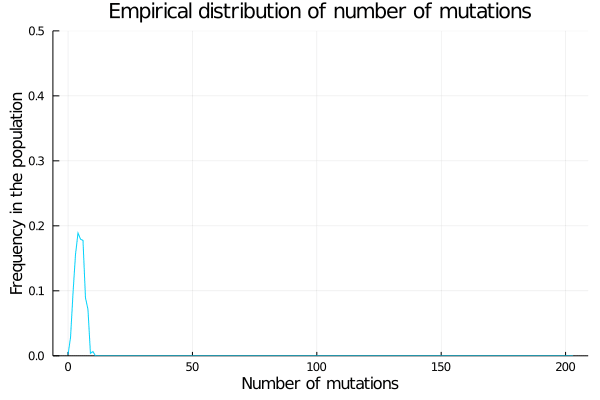

In [381]:
gen_max = size(dist_muts, 2)-1
gen_min = 1
interval = 5
dist_del_mutations_gif = Animation()
plot(title="Empirical distribution of number of mutations", xlab="Number of mutations", ylab="Frequency in the population", ylim=(0,0.5))
for i = 0:gen_max-1
    if i%interval == 0 && i <= gen_max && i >= gen_min
        plot!(0:size(dist_muts, 1)-1, dist_muts[!, i+2]/sum(dist_muts[!, i+2]), c=RGB(i/(size(dist_muts, 2)-1),(1-i/(size(dist_muts, 2)-1))^10,1-i/(size(dist_muts, 2)-1)), width=1, lab="")
        frame(dist_del_mutations_gif)
    end
end
gif(dist_del_mutations_gif, "plots/dist_muts_$(wt_reproduction_rate)_$(-s)_$(mu)_$(carrying_capacity).gif", fps = 10)

Functions to obtain minimum, maximum, mean and standard deviation of the empirical distributions as well as the population size from the dataframe:

In [363]:
function max_num_mutations(dist_generation::Vector{Int})
    max_mut = dist_generation[length(dist_generation)]
    m = 0
    while max_mut == 0
        m += 1
        max_mut = dist_generation[length(dist_generation)-m]
    end
    return length(dist_generation)-m-1
end
function max_num_mutations(distribution_mutations)
    max_mutations = Vector{Int}(undef, size(distribution_mutations, 2)-1)
    for i in eachindex(max_mutations)
        max_mutations[i] = max_num_mutations(distribution_mutations[!,i+1])
    end
    return max_mutations
end
function min_num_mutations(dist_generation::Vector{Int})
    min_mut = dist_generation[1]
    m = 1
    while min_mut == 0
        m += 1
        min_mut = dist_generation[m]
    end
    return m-1
end
function min_num_mutations(distribution_mutations)
    min_mutations = Vector{Int}(undef, size(distribution_mutations, 2)-1)
    for i in eachindex(min_mutations)
        min_mutations[i] = min_num_mutations(distribution_mutations[!,i+1])
    end
    return min_mutations
end

function mean_std_num_mutations(distribution_mutations)
    mean_num_mutations = Vector{Float64}(undef, size(distribution_mutations, 2)-1)
    std_num_mutations = Vector{Float64}(undef, size(distribution_mutations, 2)-1)
    for i in eachindex(mean_num_mutations)
        mean_num_mutations[i] = sum(distribution_mutations[!, i+1] .* distribution_mutations[!,1]) / sum(distribution_mutations[!, i+1])
        std_num_mutations[i] = (sum((distribution_mutations[!,1] .- mean_num_mutations[i]).^ 2 .* distribution_mutations[!, i+1]) / sum(distribution_mutations[!, i+1]))^0.5
    end
    return mean_num_mutations, std_num_mutations
end

function population_size(distribution_mutations)
    population_size = Vector{Int}(undef, size(distribution_mutations, 2)-1)
    for i in eachindex(population_size)
        population_size[i] = sum(distribution_mutations[!, i+1])
    end
    return population_size
end

population_size (generic function with 1 method)

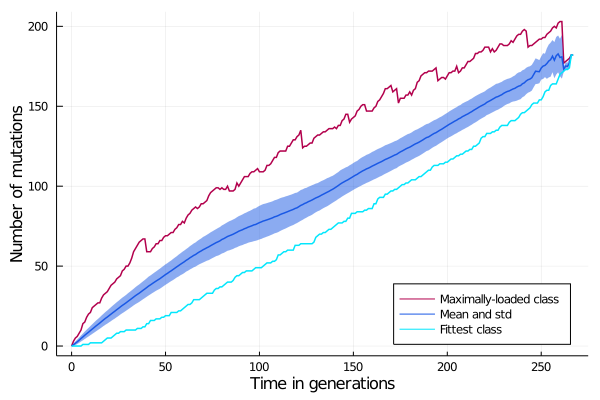

In [382]:
plot(xlab="Time in generations", ylab="Number of mutations", legend=:bottomright)
plot!(0:size(dist_muts, 2)-2, max_num_mutations(dist_muts), c=RGB(0.7, (1-0.7)^10, 1-0.7), lab="Maximally-loaded class", width=1.5)
plot!(0:size(dist_muts, 2)-2, mean_std_num_mutations(dist_muts)[1], c=RGB(0.1, (1-0.1)^10, 1-0.1), lab="Mean and std", ribbon=mean_std_num_mutations(dist_muts)[2], width=1.5)
plot!(0:size(dist_muts, 2)-2, min_num_mutations(dist_muts), c=RGB(0.01, (1-0.01)^10, 1-0.01), lab="Fittest class", width=1.5)

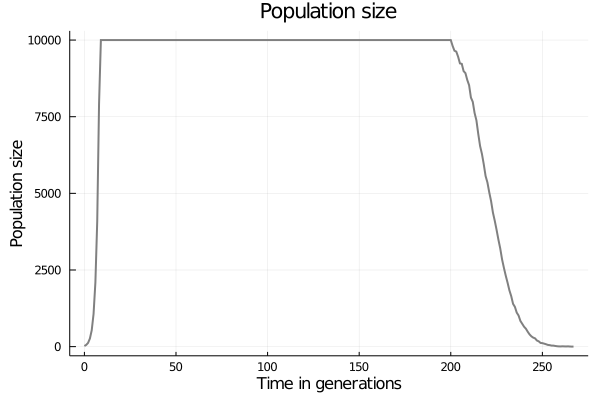

In [383]:
plot(title="Population size", xlab="Time in generations", ylab="Population size")
plot!(0:size(dist_muts, 2)-2, population_size(dist_muts), lab="", width=2, c=:grey)

## The three phases

To compare our analytical expression with the simulation results we
* calculate the time we estimate the ratchet will start (function `start_ratchet`) and the mean number of mutations as a function of the time in generations (function `mean_num_mutations`)  
* determine the time the mean number of mutations in the simulation exceeds the critical number of mutations (function `mean_below_critical`) and the estimated speed of the ratchet (function `speed_ratchet_Gessler`)
* the estimated population size during the meltdown phase (function `population_size_meltdown`)

In [385]:
function mean_below_critical(dist_muts, wt_reproduction_rate, s)
    a = 0
    for i = 2:size(dist_muts, 2)-2
        if mean_std_num_mutations(dist_muts)[1][i] > critical_number_mutations(wt_reproduction_rate, s)
            a = i
            break
        end
    end
    return a
end

mean_below_critical (generic function with 1 method)

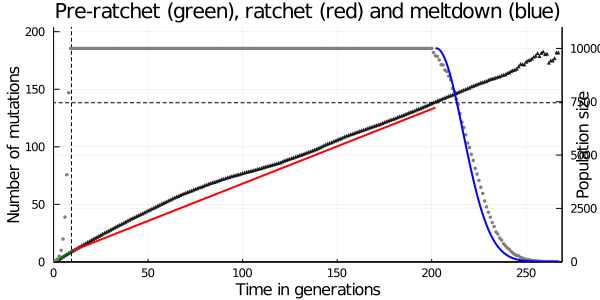

In [387]:
K = dist_muts_para.K[1]
w0 = dist_muts_para.w0[1]
s = dist_muts_para.s[1]
mu = dist_muts_para.mu[1]
m_shift = mean_below_critical(dist_muts, w0, s)
plot(title="Pre-ratchet (green), ratchet (red) and meltdown (blue)", ylim=(0, size(dist_muts, 1)), size=(600,300), xlim=(0,size(dist_muts, 2)), xlab="Time in generations", legend=:false, ylab="Number of mutations")
scatter!(0:size(dist_muts, 2)-2, mean_std_num_mutations(dist_muts)[1], c=RGB(0.1,0.1,0.1), markerstrokewidth=0, markersize=2, marker=:utriangle)
plot!(0:start_ratchet(w0, s, mu, K, 1), x->mean_num_mutations(x, s, mu), width=2, c=:green)
vline!([start_ratchet(w0, s, mu, K)], style=:dash, c=:black)
plot!(start_ratchet(w0, s, mu, K, 1):m_shift, x->mean_num_mutations(start_ratchet(w0, s, mu, K, 1), s, mu)+(x-start_ratchet(w0, s, mu, K, 1))*speed_ratchet_Gessler(s, mu, K, 1), c=:red, width=2)
hline!([critical_number_mutations(w0, s)], c=:black, style=:dash)
scatter!(twinx(), 0:size(dist_muts, 2)-2, population_size(dist_muts), c=RGB(0.5,0.5,0.5), xticks=[], xlim=(0,size(dist_muts, 2)), ylim=(-10,K*1.1), markersize=2, markerstrokewidth=0, lab="")
plot!(twinx(), m_shift:size(dist_muts, 2)-2, x -> population_size_meltdown(x-m_shift, w0, s, mu, K), c=:blue, xticks=[], xlim=(0,size(dist_muts, 2)), width=2, yticks=[], lab="", ylim=(-10, K*1.1), ylab="Population size")
#savefig("plots/pop_size_muts_$(w0)_$(-s)_$(mu)_$(K).pdf")

We want to compare the average duration of the three phases (over several simulation runs) with our analytical expressions which are given by the functions `start_ratchet`, `ratchet_time` and `meltdown_time`. First, we read the simulated data. The parameter regime we considered is given by $N_0=20$
* $w_0=2$, $K \in [10^2, 10^3, 10^4]$ and $[s,\mu] \in [-10^{-3} -10^{-2.9}, \dots, -10^{-1.5}]\times [10^{-1}, 10^{-0.95}, \dots, 10^0]$ 
* $s=-0.005, \mu=0.2$ with $w_0=2, K \in [10^2, 10^{2.2}, \dots, 10^4]$ and $ K=1000, w_0 \in [10^{0.1}, 10^{0.15}, \dots, 10^{0.6}]$ respectively

In [350]:
which_K = 2
if which_K == 1
    equilibration_time_mean = DataFrame(CSV.File("data/equilibration_time_mean_K100_41263151931079620593231864765416817756"))
    ratchet_time_mean = DataFrame(CSV.File("data/ratchet_time_mean_K100_41263151931079620593231864765416817756"))
    meltdown_time_mean = DataFrame(CSV.File("data/meltdown_time_mean_K100_41263151931079620593231864765416817756"))
    equilibration_time_var = DataFrame(CSV.File("data/equilibration_time_var_K100_41263151931079620593231864765416817756"))
    ratchet_time_var = DataFrame(CSV.File("data/ratchet_time_var_K100_41263151931079620593231864765416817756"))
    meltdown_time_var = DataFrame(CSV.File("data/meltdown_time_var_K100_41263151931079620593231864765416817756"))
    parameters = DataFrame(CSV.File("data/times_phases_parameters_K100_41263151931079620593231864765416817756"))
elseif which_K == 2
    equilibration_time_mean = DataFrame(CSV.File("data/equilibration_time_mean_K1000_408511950810458135410806347283161912613"))
    ratchet_time_mean = DataFrame(CSV.File("data/ratchet_time_mean_K1000_408511950810458135410806347283161912613"))
    meltdown_time_mean = DataFrame(CSV.File("data/meltdown_time_mean_K1000_408511950810458135410806347283161912613"))
    equilibration_time_var = DataFrame(CSV.File("data/equilibration_time_var_K1000_408511950810458135410806347283161912613"))
    ratchet_time_var = DataFrame(CSV.File("data/ratchet_time_var_K1000_408511950810458135410806347283161912613"))
    meltdown_time_var = DataFrame(CSV.File("data/meltdown_time_var_K1000_408511950810458135410806347283161912613"))
    parameters = DataFrame(CSV.File("data/times_phases_parameters_K1000_408511950810458135410806347283161912613"))
elseif which_K == 3
    equilibration_time_mean = DataFrame(CSV.File("data/equilibration_time_mean_K10000_399155121639959885414695084793876067713"))
    ratchet_time_mean = DataFrame(CSV.File("data/ratchet_time_mean_K10000_399155121639959885414695084793876067713"))
    meltdown_time_mean = DataFrame(CSV.File("data/meltdown_time_mean_K10000_399155121639959885414695084793876067713"))
    equilibration_time_var = DataFrame(CSV.File("data/equilibration_time_var_K10000_399155121639959885414695084793876067713"))
    ratchet_time_var = DataFrame(CSV.File("data/ratchet_time_var_K10000_399155121639959885414695084793876067713"))
    meltdown_time_var = DataFrame(CSV.File("data/meltdown_time_var_K10000_399155121639959885414695084793876067713"))
    parameters = DataFrame(CSV.File("data/times_phases_parameters_K10000_399155121639959885414695084793876067713"))
end

,runs,w0,N0,K,genmax,SEED
,Int64,Float64,Int64,Int64,Int64,Int64
1,50,2.0,20,1000,20000,4085119508
2,50,2.0,20,1000,20000,104581354
3,50,2.0,20,1000,20000,1080634728
4,50,2.0,20,1000,20000,3161912613


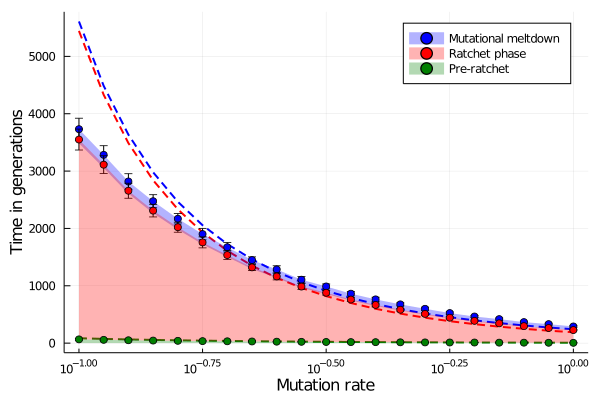

In [353]:
K = parameters.K[1]
w0 = parameters.w0[1]
which_s = 8
s = -[10^parse(Float64, names(equilibration_time_mean)[i]) for i = 2:size(equilibration_time_mean, 2)][which_s]
mu_range = reverse(10 .^ equilibration_time_mean[:,1])
plot(xscale=:log10, xlab="Mutation rate", ylab="Time in generations")
plot!(mu_range, x -> extinction_time(w0, s, x, K), lab="", width=2, c=:blue, style=:dash)
plot!(mu_range, x -> start_ratchet(w0, s, x, K)+ratchet_time(w0, s, x, K), lab="", width=2, c=:red, style=:dash)
plot!(mu_range, x -> start_ratchet(w0, s, x, K), lab="", width=2, c=:green, style=:dash)
scatter!(mu_range, reverse(meltdown_time_mean[:,which_s].+ratchet_time_mean[:,which_s].+equilibration_time_mean[:,which_s]), yerror=reverse((meltdown_time_var[:,which_s].+ratchet_time_var[:,which_s].+equilibration_time_var[:,which_s]).^0.5), lab="Mutational meltdown", c=:blue, fillrange=reverse(ratchet_time_mean[:,which_s]), fillalpha=0.3)
scatter!(mu_range, reverse(ratchet_time_mean[:,which_s].+equilibration_time_mean[:,which_s]), yerror=reverse((ratchet_time_var[:,which_s].+equilibration_time_var[:,which_s]).^0.5), lab="Ratchet phase", c=:red, fillrange=reverse(equilibration_time_mean[:,which_s]), fillalpha=0.3)
scatter!(mu_range, reverse(equilibration_time_mean[:,which_s]), yerror=reverse(equilibration_time_var[:,which_s].^0.5), lab="Pre-ratchet", c=:green, fill=(1), fillalpha=0.3)
#savefig("plots/phases_mu_s$(-s).pdf")

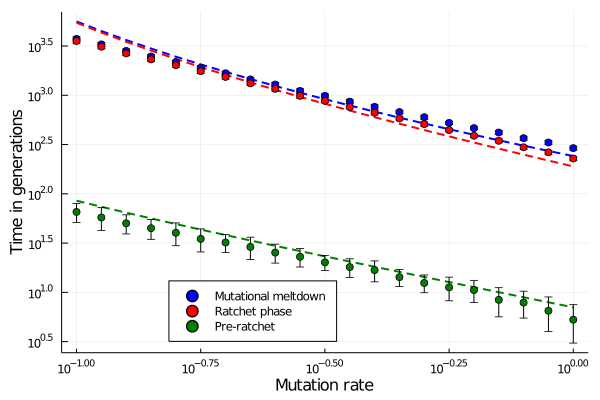

In [355]:
plot(yscale=:log10, xscale=:log10, xlab="Mutation rate", ylab="Time in generations", legend=:bottom)
plot!(mu_range, x -> extinction_time(w0, s, x, K), lab="", width=2, c=:blue, style=:dash)
plot!(mu_range, x -> start_ratchet(w0, s, x, K)+ratchet_time(w0, s, x, K), lab="", width=2, c=:red, style=:dash)
plot!(mu_range, x -> start_ratchet(w0, s, x, K), lab="", width=2, c=:green, style=:dash)
scatter!(mu_range, reverse(meltdown_time_mean[:,which_s].+ratchet_time_mean[:,which_s].+equilibration_time_mean[:,which_s]), yerror=reverse((meltdown_time_var[:,which_s].+ratchet_time_var[:,which_s].+equilibration_time_var[:,which_s]).^0.5), lab="Mutational meltdown", c=:blue)
scatter!(mu_range, reverse(ratchet_time_mean[:,which_s].+equilibration_time_mean[:,which_s]), yerror=reverse((ratchet_time_var[:,which_s].+equilibration_time_var[:,which_s]).^0.5), lab="Ratchet phase", c=:red)
scatter!(mu_range, reverse(equilibration_time_mean[:,which_s]), yerror=reverse(equilibration_time_var[:,which_s].^0.5), lab="Pre-ratchet", c=:green)
#savefig("plots/phases_log_mu_s$(-s).pdf")

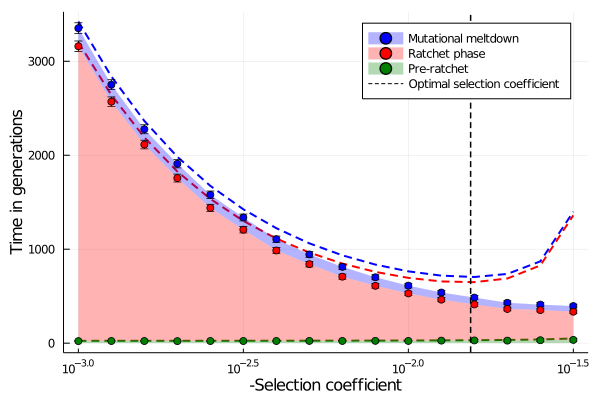

In [357]:
w0 = parameters.w0[1]
K = parameters.K[1]
which_mu = 12
mu = 10 .^ equilibration_time_mean[:,1][which_mu]
s_range = [10^parse(Float64, names(equilibration_time_mean)[i]) for i = 2:size(equilibration_time_mean, 2)]
s_opt = -optimal_s(w0, mu, K, minimum(-s_range), maximum(-s_range))
plot(xscale=:log10, xlab="-Selection coefficient", ylab="Time in generations")
plot!(s_range, x -> extinction_time(w0, -x, mu, K), lab="", width=2, c=:blue, style=:dash)
plot!(s_range, x -> start_ratchet(w0, -x, mu, K)+ratchet_time(w0, -x, mu, K), lab="", width=2, c=:red, style=:dash)
plot!(s_range, x -> start_ratchet(w0, -x, mu, K), lab="", width=2, c=:green, style=:dash)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]).+Vector(meltdown_time_mean[which_mu, 2:end]), yerror=(Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]).+Vector(meltdown_time_mean[which_mu, 2:end])).^0.5, lab="Mutational meltdown", c=:blue, fillrange=Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]), fillalpha=0.3)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]), yerror=(Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end])).^0.5, lab="Ratchet phase", c=:red, fillrange=Vector(equilibration_time_mean[which_mu, 2:end]), fillalpha=0.3)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]), yerror=Vector(equilibration_time_var[which_mu, 2:end]).^0.5, lab="Pre-ratchet", c=:green, fill=(1), fillalpha=0.3)
vline!([s_opt], lab="Optimal selection coefficient", c=:black, style=:dash, width=1.5)
#savefig("plots/phases_s_mu$(mu)_K_$K.pdf")

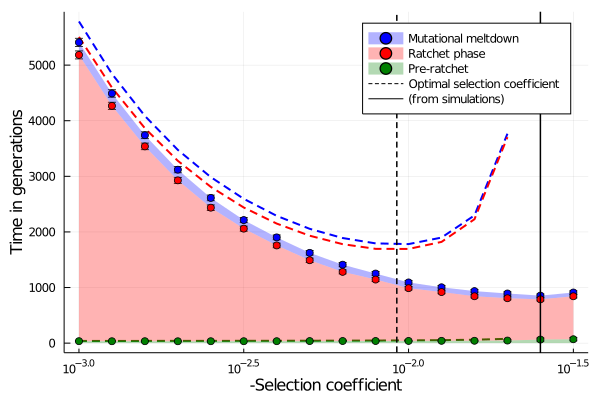

In [360]:
w0 = parameters.w0[1]
K = parameters.K[1]
which_mu = 16
mu = 10 .^ equilibration_time_mean[:,1][which_mu]
s_opt = -optimal_s(w0, mu, K, minimum(-s_range), maximum(-s_range))
plot(xscale=:log10, xlab="-Selection coefficient", ylab="Time in generations")
plot!(s_range, x -> extinction_time(w0, -x, mu, K), lab="", width=2, c=:blue, style=:dash)
plot!(s_range, x -> start_ratchet(w0, -x, mu, K)+ratchet_time(w0, -x, mu, K), lab="", width=2, c=:red, style=:dash)
plot!(s_range, x -> start_ratchet(w0, -x, mu, K), lab="", width=2, c=:green, style=:dash)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]).+Vector(meltdown_time_mean[which_mu, 2:end]), yerror=(Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]).+Vector(meltdown_time_mean[which_mu, 2:end])).^0.5, lab="Mutational meltdown", c=:blue, fillrange=Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]), fillalpha=0.3)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]), yerror=(Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end])).^0.5, lab="Ratchet phase", c=:red, fillrange=Vector(equilibration_time_mean[which_mu, 2:end]), fillalpha=0.3)
scatter!(s_range, Vector(equilibration_time_mean[which_mu, 2:end]), yerror=Vector(equilibration_time_var[which_mu, 2:end]).^0.5, lab="Pre-ratchet", c=:green, fill=(1), fillalpha=0.3)
vline!([s_opt], lab="Optimal selection coefficient", c=:black, width=1.5, style=:dash)
vline!([s_range[argmin(Vector(equilibration_time_mean[which_mu, 2:end]).+Vector(ratchet_time_mean[which_mu, 2:end]).+Vector(meltdown_time_mean[which_mu, 2:end]))]], c=:black, width=1.5, lab="(from simulations)")
#savefig("plots/phases_s_mu$(mu)_K_$K.pdf")

In [304]:
# w0 = 2, s = -0.005, mu = 0.27
times_phases_K = DataFrame(CSV.File("data/times_phases_K_4069610302349402006415121656192341288399"))
times_phases_K_para = DataFrame(CSV.File("data/times_phases_parameters_K_4069610302349402006415121656192341288399"))
# K = 1000, s = -0.005, mu = 0.27
times_phases_w0 = DataFrame(CSV.File("data/times_phases_w0_215693278617691592212989151792123172373"))
times_phases_w0_para = DataFrame(CSV.File("data/times_phases_parameters_w0_215693278617691592212989151792123172373"));

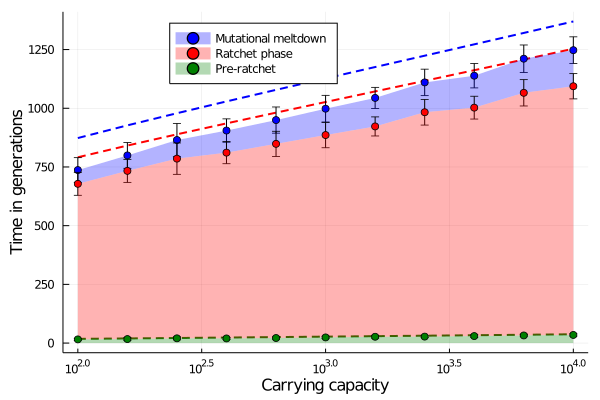

In [369]:
w0 = times_phases_K_para.w0[1]
mu = times_phases_K_para.mu_del[1]
s = times_phases_K_para.s_del[1]
run_K = [10^parse(Float64, names(times_phases_K)[i]) for i = 2:size(times_phases_K, 2)]
plot(xscale=:log10, xlab="Carrying capacity", ylab="Time in generations", legend=:top)
plot!(run_K, x -> extinction_time(w0, s, mu, x), lab="", width=2, c=:blue, style=:dash)
plot!(run_K, x -> start_ratchet(w0, s, mu, x)+ratchet_time(w0, s, mu, x), lab="", width=2, c=:red, style=:dash)
plot!(run_K, x -> start_ratchet(w0, s, mu, x), lab="", width=2, c=:green, style=:dash)
scatter!(run_K, Vector(times_phases_K[1, 2:end]).+Vector(times_phases_K[3, 2:end]).+Vector(times_phases_K[5, 2:end]), yerror=(Vector(times_phases_K[2, 2:end]).+Vector(times_phases_K[4, 2:end]).+Vector(times_phases_K[6, 2:end])).^0.5, lab="Mutational meltdown", c=:blue, fillrange=Vector(times_phases_K[1, 2:end]).+Vector(times_phases_K[3, 2:end]), fillalpha=0.3)
scatter!(run_K, Vector(times_phases_K[1, 2:end]).+Vector(times_phases_K[3, 2:end]), yerror=(Vector(times_phases_K[2, 2:end]).+Vector(times_phases_K[4, 2:end])).^0.5, lab="Ratchet phase", c=:red, fillrange=Vector(times_phases_K[1, 2:end]), fillalpha=0.3)
scatter!(run_K, Vector(times_phases_K[1, 2:end]), yerror=Vector(times_phases_K[2, 2:end]).^0.5, lab="Pre-ratchet", c=:green, fill=(0), fillalpha=0.3)
#savefig("plots/phases_K.pdf")

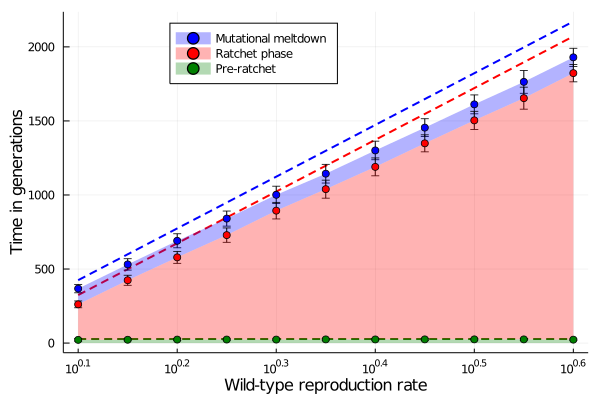

In [370]:
K = times_phases_w0_para.K[1]
mu = times_phases_w0_para.mu_del[1]
s = times_phases_w0_para.s_del[1]
w0_range = [10^parse(Float64, names(times_phases_w0)[i]) for i = 2:size(times_phases_w0, 2)]
plot(xscale=:log10, xlab="Wild-type reproduction rate", ylab="Time in generations", legend=:top)
plot!(w0_range[1:11], x -> extinction_time(x, s, mu, K), lab="", width=2, c=:blue, style=:dash)
plot!(w0_range[1:11], x -> start_ratchet(x, s, mu, K)+ratchet_time(x, s, mu, K), lab="", width=2, c=:red, style=:dash)
plot!(w0_range[1:11], x -> start_ratchet(x, s, mu, K), lab="", width=2, c=:green, style=:dash)
scatter!(w0_range[1:11], Vector(times_phases_w0[1, 2:12]).+Vector(times_phases_w0[3, 2:12]).+Vector(times_phases_w0[5, 2:12]), yerror=(Vector(times_phases_w0[2, 2:12]).+Vector(times_phases_w0[4, 2:12]).+Vector(times_phases_w0[6, 2:12])).^0.5, lab="Mutational meltdown", c=:blue, fillrange=Vector(times_phases_w0[1, 2:12]).+Vector(times_phases_w0[3, 2:12]), fillalpha=0.3)
scatter!(w0_range[1:11], Vector(times_phases_w0[1, 2:12]).+Vector(times_phases_w0[3, 2:12]), yerror=(Vector(times_phases_w0[2, 2:12]).+Vector(times_phases_w0[4, 2:12])).^0.5, lab="Ratchet phase", c=:red, fillrange=Vector(times_phases_w0[1, 2:12]), fillalpha=0.3)
scatter!(w0_range[1:11], Vector(times_phases_w0[1, 2:12]), yerror=Vector(times_phases_w0[2, 2:12]).^0.5, lab="Pre-ratchet", c=:green, fill=(0), fillalpha=0.3)
#savefig("plots/phases_w0.pdf")

## Quantifying the error

Next, we compare the estimated mean extinction time with the mean extinction time obtained from simulations, calculate the relative error and the coefficient of variation (of the extinction time obtained from simulations). In principle, the same can be done for the start of the ratchet or the mutational meltdown respectively.

In [371]:
K = parameters.K[1]
w0 = parameters.w0[1]
mu_range = reverse(10 .^ equilibration_time_mean[:,1])
s_range = [10^parse(Float64, names(equilibration_time_mean)[i]) for i = 2:size(equilibration_time_mean, 2)]

mean_ext = Matrix(equilibration_time_mean[end:-1:1,2:end].+ratchet_time_mean[end:-1:1,2:end].+meltdown_time_mean[end:-1:1,2:end])
var_ext = Matrix(equilibration_time_var[end:-1:1,2:end].+ratchet_time_var[end:-1:1,2:end].+meltdown_time_var[end:-1:1,2:end])
cvar_ext = var_ext.^0.5 ./ mean_ext
ana_ext = Matrix{Float64}(undef, (length(mu_range), length(s_range)))
for i = 1:length(mu_range)
    for j = 1:length(s_range)
        ana_ext[i,j] = extinction_time(w0, -s_range[j], mu_range[i], K)
    end
end
s_opt = Vector{Float64}(undef, length(mu_range))
ana_opt = Vector{Float64}(undef, length(mu_range))
ana_opt_Gabriel = Vector{Float64}(undef, length(mu_range))
for i = 1:size(mean_ext, 1)
    s_opt[i] = s_range[argmin(mean_ext[i,:])]
    ana_opt[i] = -optimal_s(w0, mu_range[i], K, -maximal_s(mu_range[i], K), maximum(-s_range))
    ana_opt_Gabriel[i] = - optimal_s_Gabriel(mu_range[i], K)
end
err_rel = (ana_ext .- mean_ext) ./ mean_ext;

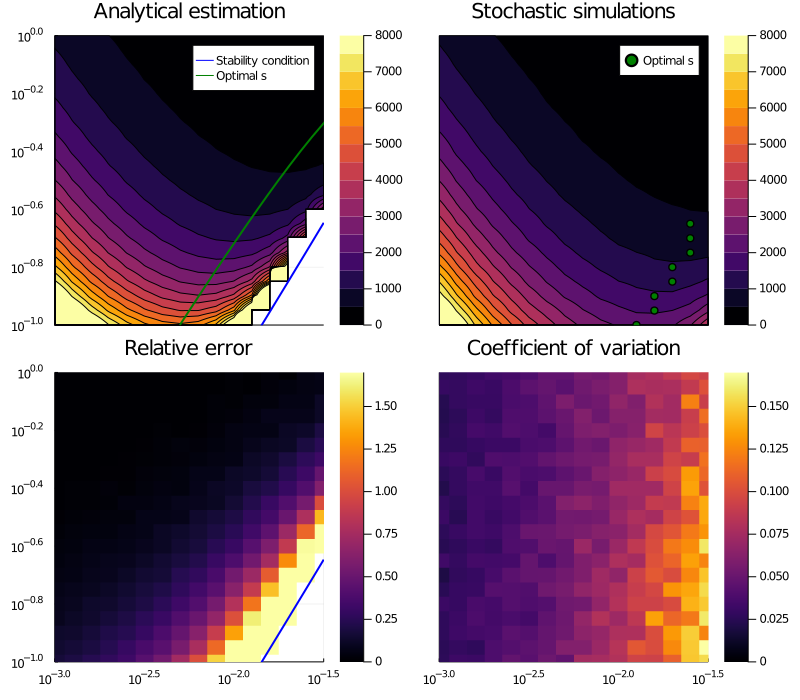

In [372]:
Tmax = parameters.genmax[1]/2
A = plot(title="Analytical estimation", xscale=:log10, yscale=:log10, ylim=(minimum(mu_range), maximum(mu_range)), xlim=(minimum(s_range), maximum(s_range)))
contourf!(s_range, mu_range, ana_ext, clims=(0, 8000), xticks=false)#, colorbar_title="Extinction time in generations")
plot!(s_range, x->x*log(K)/(1-x), lab="Stability condition", width=2, c=:blue)
plot!(ana_opt, mu_range, lab="Optimal s", width=2, c=:green)
M = plot(title="Stochastic simulations", xscale=:log10, yscale=:log10, ylim=(minimum(mu_range), maximum(mu_range)), xlim=(minimum(s_range), maximum(s_range)))
contourf!(s_range, mu_range, mean_ext, clims=(0, 8000), xticks=false, yticks=[])
scatter!(s_opt[1:9], mu_range[1:9], lab="Optimal s", width=2, c=:green)
R = plot(title="Relative error", xscale=:log10, yscale=:log10, ylim=(minimum(mu_range), maximum(mu_range)), xlim=(minimum(s_range), maximum(s_range)))
heatmap!(s_range, mu_range, (ana_ext.-mean_ext)./mean_ext, clim=(0,1.7))
plot!(s_range, x->x*log(K)/(1-x), lab="", width=2, c=:blue)
C = plot(title="Coefficient of variation", xscale=:log10, yscale=:log10, ylim=(minimum(mu_range), maximum(mu_range)), xlim=(minimum(s_range), maximum(s_range)))
heatmap!(s_range, mu_range, var_ext.^0.5./mean_ext, yticks=false, clim=(0,0.17))
P = plot(A, M, R, C, layout=4, size=(800,700))#, legend=:false, title=" ", tickfontsize=11)
#savefig(P, "plots/ana_sim_rel_cvar_K$K.pdf")

In [37]:
((ana_ext.-mean_ext)./mean_ext)[which_mu, which_s], ((ana_ext.-mean_ext)./mean_ext)[end, which_s]

(0.1249307212701036, -0.0026783349505441144)

In [38]:
maximal_s(mu_range[which_mu],K), maximal_s(mu_range[end], K)

(0.0425357416532812, 0.16926902906044083)

In [44]:
minimum(ana_ext), minimum(mean_ext), maximum(mean_ext)

(70.6022419017384, 66.03999999999999, 9984.14)

## Muller's ratchet 

The speed of the ratchet and, therefore, the ratchet phase is the most difficult to quantify. We compare different estimates from the literature, by Pamilo et al. ($v_R = \mu - s \ln(K)$, function `speed_ratchet_Pamilo`), Gessler and Lynch et al ($v_R = \frac{\mu (1-s)}{1+Ks}$, function `speed_ratchet_Lynch`). Gesslers estimate (function `speed_ratchet_Gessler`) shows a non-monotonic dependence with respect to the relevant parameters which is why we derived a smooth continuation of the expression.

In [332]:
speed_mu = DataFrame(CSV.File("data/ratchet_speeds_mu_del_1428484780309707794634921702461701948920"))
speed_mu_para = DataFrame(CSV.File("data/ratchet_speeds_mu_del_para_1428484780309707794634921702461701948920"))
mu_range = [10^parse(Float64, names(speed_mu)[i]) for i = 2:size(speed_mu, 2)]
speed_mean_mu = Vector{Float64}(undef, length(mu_range))
for i in eachindex(speed_mean_mu)
    speed_mean_mu[i] = mean(speed_mu[:,i+1])
end
speed_mean_mu
speed_std_mu = Vector{Float64}(undef, length(mu_range))
for i in eachindex(speed_std_mu)
    speed_std_mu[i] = std(speed_mu[:,i+1])
end

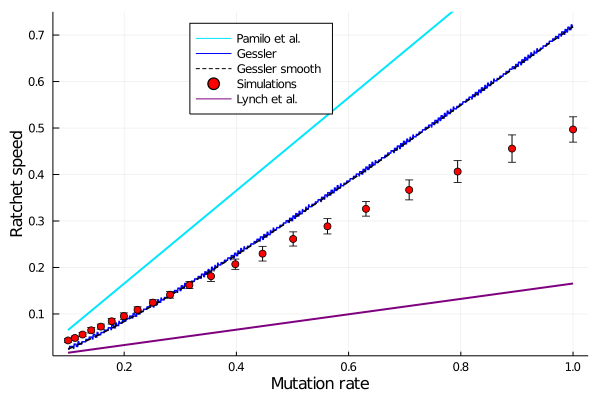

In [373]:
w0 = speed_mu_para.w0[1]
s = speed_mu_para.s_del[1]
K = speed_mu_para.K[1]
plot(ylim=(0.01,0.75), xlab="Mutation rate", ylab="Ratchet speed", legend=:top)
plot!(minimum(mu_range):0.001:maximum(mu_range), x->speed_ratchet_Pamilo(s, x, K), width=2, c=RGB(0.01, (1-0.01)^10, 1-0.01), lab="Pamilo et al.")
plot!(minimum(mu_range):0.001:maximum(mu_range), x->speed_ratchet_Gessler(s, x, K), width=1.5, c=:blue, lab="Gessler")
plot!(minimum(mu_range):0.001:maximum(mu_range), x->speed_ratchet_Gessler(s, x, K, 1), width=1.5, style=:dash, c=:black, lab="Gessler smooth")
scatter!(mu_range, speed_mean_mu, yerror=speed_std_mu, c=:red, lab="Simulations")
plot!(minimum(mu_range):0.001:maximum(mu_range), x->speed_ratchet_Lynch(s, x, K), width=2, c=RGB(0.5, (1-0.5)^10, 1-0.5), lab="Lynch et al.")
#savefig("plots/speed_mu.pdf")

In [336]:
speed_s = DataFrame(CSV.File("data/ratchet_speeds_s_del_238952330329689363901008759593658467445"))
speed_s_para = DataFrame(CSV.File("data/ratchet_speeds_s_del_para_238952330329689363901008759593658467445"))
s_range = [10^parse(Float64, names(speed_s)[i]) for i = 2:size(speed_s, 2)]
speed_mean_s = Vector{Float64}(undef, length(s_range))
for i in eachindex(speed_mean_s)
    speed_mean_s[i] = mean(speed_s[:,i+1])
end
speed_std_s = Vector{Float64}(undef, length(s_range))
for i in eachindex(speed_std_s)
    speed_std_s[i] = std(speed_s[:,i+1])
end

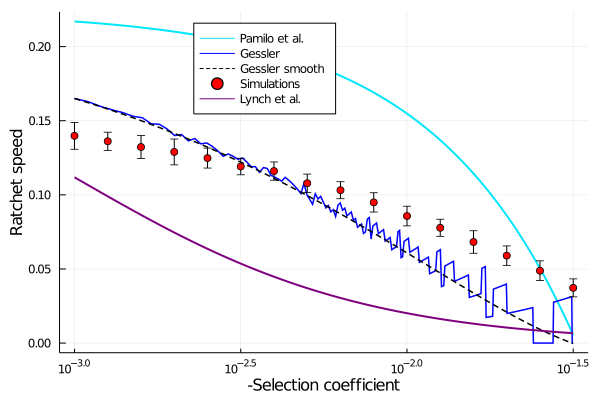

In [375]:
w0 = speed_s_para.w0[1]
mu_del = speed_s_para.mu_del[1]
K = speed_s_para.K[1]
plot(xscale=:log10, xlab="-Selection coefficient", ylab="Ratchet speed", legend=:top)
plot!(minimum(s_range):0.0001:maximum(s_range), x->speed_ratchet_Pamilo(-x, mu_del, K), width=2, c=RGB(0.01, (1-0.01)^10, 1-0.01), lab="Pamilo et al.")
plot!(minimum(s_range):0.0001:maximum(s_range), x->speed_ratchet_Gessler(-x, mu_del, K), width=1.5, c=:blue, lab="Gessler")
plot!(minimum(s_range):0.0001:maximum(s_range), x->speed_ratchet_Gessler(-x, mu_del, K, 1), width=1.5, style=:dash, c=:black, lab="Gessler smooth")
scatter!(s_range, speed_mean_s, yerror=speed_std_s, c=:red, lab="Simulations")
plot!(minimum(s_range):0.0001:maximum(s_range), x->speed_ratchet_Lynch(-x, mu_del, K), width=2, c=RGB(0.5, (1-0.5)^10, 1-0.5), lab="Lynch et al.")
#savefig("plots/speed_s.pdf")

In [339]:
speed_K = DataFrame(CSV.File("data/ratchet_speeds_K_1553646279104838355540445932883128688704"))
speed_K_para = DataFrame(CSV.File("data/ratchet_speeds_K_para_1553646279104838355540445932883128688704"))
K_range = [10^parse(Float64, names(speed_K)[i]) for i = 2:size(speed_K, 2)]
speed_mean_K = Vector{Float64}(undef, length(K_range))
for i in eachindex(speed_mean_K)
    speed_mean_K[i] = mean(speed_K[:,i+1])
end
speed_std_K = Vector{Float64}(undef, length(K_range))
for i in eachindex(speed_std_K)
    speed_std_K[i] = std(speed_K[:,i+1])
end

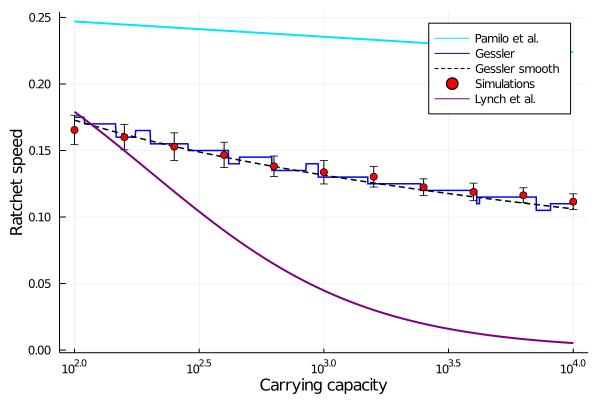

In [376]:
w0 = speed_K_para.w0[1]
mu_del = speed_K_para.mu_del[1]
s_del = speed_K_para.s_del[1]
plot(xscale=:log10, xlab="Carrying capacity", ylab="Ratchet speed")
plot!(minimum(K_range):maximum(K_range), x->speed_ratchet_Pamilo(s_del, mu_del, x), width=2, c=RGB(0.01, (1-0.01)^10, 1-0.01), lab="Pamilo et al.")
plot!(minimum(K_range):maximum(K_range), x->speed_ratchet_Gessler(s_del, mu_del, x), width=1.5, c=:blue, lab="Gessler")
plot!(minimum(K_range):maximum(K_range), x->speed_ratchet_Gessler(s_del, mu_del, x, 1), width=1.5, style=:dash, c=:black, lab="Gessler smooth")
scatter!(K_range, speed_mean_K, yerror=speed_std_K, c=:red, lab="Simulations")
plot!(minimum(K_range):maximum(K_range), x->speed_ratchet_Lynch(s_del, mu_del, x), width=2, c=RGB(0.5, (1-0.5)^10, 1-0.5), lab="Lynch et al.")
#savefig("plots/speed_K.pdf")

In [378]:
speed_w0 = DataFrame(CSV.File("data/ratchet_speeds_w0_143521362338503317693395640538952736655"))
speed_w0_para = DataFrame(CSV.File("data/ratchet_speeds_w0_para_143521362338503317693395640538952736655"))
w0_range = [10^parse(Float64, names(speed_w0)[i]) for i = 2:size(speed_w0, 2)]
speed_mean_w0 = Vector{Float64}(undef, length(w0_range))
for i in eachindex(speed_mean_w0)
    speed_mean_w0[i] = mean(speed_w0[:,i+1])
end
speed_std_w0 = Vector{Float64}(undef, length(w0_range))
for i in eachindex(speed_std_w0)
    speed_std_w0[i] = std(speed_w0[:,i+1])
end

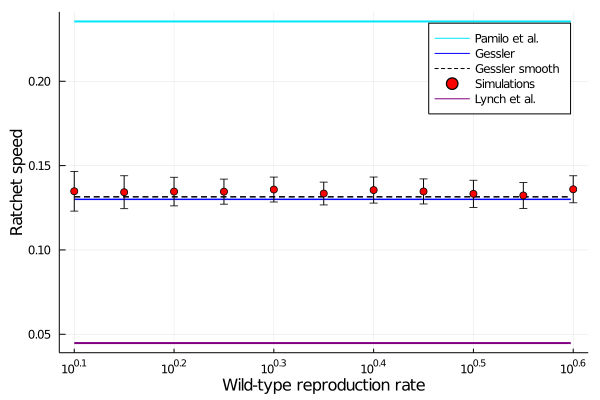

In [379]:
K = speed_w0_para.K[1]
mu_del = speed_w0_para.mu_del[1]
s_del = speed_w0_para.s_del[1]
plot(xscale=:log10, xlab="Wild-type reproduction rate", ylab="Ratchet speed")
plot!(minimum(w0_range):0.1:maximum(w0_range), x->speed_ratchet_Pamilo(s_del, mu_del, K), width=2, c=RGB(0.01, (1-0.01)^10, 1-0.01), lab="Pamilo et al.")
plot!(minimum(w0_range):0.1:maximum(w0_range), x->speed_ratchet_Gessler(s_del, mu_del, K), width=1.5, c=:blue, lab="Gessler")
plot!(minimum(w0_range):0.1:maximum(w0_range), x->speed_ratchet_Gessler(s_del, mu_del, K, 1), width=1.5, style=:dash, c=:black, lab="Gessler smooth")
scatter!(w0_range, speed_mean_w0, yerror=speed_std_w0, c=:red, lab="Simulations")
plot!(minimum(w0_range):0.1:maximum(w0_range), x->speed_ratchet_Lynch(s_del, mu_del, K), width=2, c=RGB(0.5, (1-0.5)^10, 1-0.5), lab="Lynch et al.")
#savefig("plots/speed_w0.pdf")